### This notebook contains code for generating batch-corrected versions of the RNAseq data in the 24q2 data release and uploading them to Taiga.

In [1]:
from taigapy import TaigaClient
import pandas as pd
from inmoose.pycombat import pycombat_norm, pycombat_seq
import numpy as np

In [2]:
tc = TaigaClient()

In [3]:
OmicsExpressionProteinCodingGenesTPMLogp1_internal = tc.get(name='internal-24q2-3719', version=63, file='OmicsExpressionProteinCodingGenesTPMLogp1')
OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal = tc.get(name='internal-24q2-3719', version=63, file='OmicsExpressionProteinCodingGenesTPMLogp1Stranded')

OmicsExpressionProteinCodingGenesTPMLogp1_public = tc.get(name='public-24q2-356f', version=33, file='OmicsExpressionProteinCodingGenesTPMLogp1')
OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public = tc.get(name='public-24q2-356f', version=33, file='OmicsExpressionProteinCodingGenesTPMLogp1Stranded')

OmicsExpressionProteinCodingGenesTPMLogp1_dmc = tc.get(name='dmc-24q2-5194', version=40, file='OmicsExpressionProteinCodingGenesTPMLogp1')
OmicsExpressionProteinCodingGenesTPMLogp1Stranded_dmc = tc.get(name='dmc-24q2-5194', version=40, file='OmicsExpressionProteinCodingGenesTPMLogp1Stranded')

In [189]:
OmicsProfiles_internal = tc.get(name='internal-24q2-3719', version=63, file='OmicsProfiles')
OmicsProfiles_public = tc.get(name='public-24q2-356f', version=2, file='OmicsProfiles')
OmicsProfiles_dmc = tc.get(name='dmc-24q2-5194', version=2, file='OmicsProfiles')

[##################]100% |  25.7 MiB/s |  61.5 KiB /  61.5 KiB | ETA:  00:00:00


In [190]:
OmicsDefaultModelProfiles_internal = tc.get(name='internal-24q2-3719', version=63, file='OmicsDefaultModelProfiles')
OmicsDefaultModelProfiles_public = tc.get(name='public-24q2-356f', version=2, file='OmicsDefaultModelProfiles')
OmicsDefaultModelProfiles_dmc = tc.get(name='dmc-24q2-5194', version=2, file='OmicsDefaultModelProfiles')

[##################]100% |  16.5 MiB/s |  27.8 KiB /  27.8 KiB | ETA:  00:00:00
[##################]100% |  14.9 MiB/s |  35.7 KiB /  35.7 KiB | ETA:  00:00:00


### Internal

Retreive profile IDs for internal and filter based on strandedness. Some profile IDs correspond to the same model ID, so remove duplicates using OmicsDefaultModelProfiles.

In [155]:
nonstranded_profiles = OmicsProfiles_internal[OmicsProfiles_internal['Stranded'] == False]['ProfileID']

In [156]:
nonstranded_model_ids = OmicsDefaultModelProfiles_internal[OmicsDefaultModelProfiles_internal['ProfileID'].isin(nonstranded_profiles)]['ModelID']

In [157]:
stranded_profiles = OmicsProfiles_internal[OmicsProfiles_internal['Stranded'] == True]['ProfileID']

In [163]:
stranded_model_ids = OmicsDefaultModelProfiles_internal[OmicsDefaultModelProfiles_internal['ProfileID'].isin(stranded_profiles)]['ModelID']

In [166]:
len(nonstranded_model_ids), len(stranded_model_ids)

(986, 1003)

Find overlapping gene names between the original expression dataset (includes unstranded RNAseq w/ unstranded RSEM mode + stranded RNAseq w/ unstranded RSEM mode) and new expression dataset (stranded RNAseq w/ stranded RSEM mode). 

In [175]:
genes_overlap_ids = list(set(OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal.loc[stranded_model_ids].columns).intersection(set(OmicsExpressionProteinCodingGenesTPMLogp1_internal.loc[nonstranded_model_ids].columns)))

In [176]:
nonstranded_24q2 = OmicsExpressionProteinCodingGenesTPMLogp1_internal.loc[nonstranded_model_ids, genes_overlap_ids]

In [177]:
stranded_24q2 = OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal.loc[stranded_model_ids, genes_overlap_ids]

In [178]:
tpm_24q2 = pd.concat((nonstranded_24q2, stranded_24q2), axis=0)

In [179]:
tpm_24q2

,ZNF891 (101060200),ARMC10 (83787),PTGER4 (5734),EIF1AD (84285),ABCG5 (64240),CXCR4 (7852),CAPNS1 (826),PTGES3L (100885848),DESI1 (27351),STAU2 (27067),...,FAM13C (220965),MUC20 (200958),MST1R (4486),TELO2 (9894),THSD8 (10535),FCRL6 (343413),DNMT3B (1789),ZCCHC10 (54819),PRSS2 (5645),ADAMTSL4 (54507)
ACH-000058,1.049631,4.526695,2.137504,4.558268,0.014355,3.017922,8.785354,1.356144,4.914565,5.373648,...,3.588565,1.056584,1.014355,5.137913,0.526069,0.124328,2.548437,4.934517,0.226509,1.480265
ACH-000082,1.416840,4.003602,2.039138,5.940637,0.000000,0.137504,8.680465,1.182692,5.183883,4.408032,...,2.364572,0.887525,0.137504,5.340562,1.565597,0.014355,2.704872,4.590362,0.286881,0.933573
ACH-000867,0.807355,4.691534,4.282440,5.063503,0.000000,0.189034,8.774458,1.292782,4.067811,3.189034,...,0.000000,1.097611,4.657640,4.791293,0.650765,0.014355,2.283922,4.450881,0.321928,6.481396
ACH-000437,1.682573,5.637784,3.518535,4.861955,0.000000,2.344828,8.734506,0.000000,4.955127,3.950468,...,1.298658,0.250962,0.757023,5.381283,0.124328,0.000000,2.469886,4.718088,0.321928,1.333424
ACH-000544,0.575312,5.702935,0.687061,4.048759,0.000000,0.226509,7.221490,0.526069,3.060047,3.575312,...,0.042644,0.485427,2.794936,4.127633,0.411426,0.000000,1.560715,4.511595,0.042644,0.847997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-001338,0.731183,5.266037,0.000000,5.009885,0.000000,0.367371,7.989309,3.508429,5.151778,5.163096,...,3.258519,0.250962,0.028569,2.827819,0.669027,0.000000,2.784504,4.925525,0.000000,0.163499
ACH-001085,0.956057,4.543496,2.981853,4.769772,0.042644,5.928844,8.326025,1.207893,5.023699,5.170326,...,1.555816,0.056584,1.014355,3.277985,0.163499,0.000000,3.084064,5.105175,0.163499,0.678072
ACH-001163,0.941106,5.176323,0.111031,4.960234,0.000000,1.356144,8.881848,0.367371,4.206331,4.545968,...,0.084064,0.214125,3.330558,3.600508,1.014355,0.000000,1.855990,5.764474,0.000000,1.400538
ACH-001611,1.536053,4.753284,2.039138,4.776104,0.000000,0.000000,10.308794,1.298658,4.530445,4.905928,...,3.104337,0.941106,0.214125,4.442280,0.613532,0.042644,1.867896,4.972233,0.000000,0.659925


In [180]:
strandness = np.array([0] * len(nonstranded_model_ids) + [1] * len(stranded_model_ids))

In [182]:
tpm_corrected_24q2 = pycombat_norm(tpm_24q2.T, strandness)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[[0.52474104]
 [0.6101267 ]
 [1.37105939]
 ...
 [0.57921899]
 [2.07502496]
 [1.68218147]] [[False False False ... False False False]]
[[0.52474104 0.52474104 0.52474104 ... 0.52474104 0.52474104 0.52474104]
 [0.6101267  0.6101267  0.6101267  ... 0.6101267  0.6101267  0.6101267 ]
 [1.37105939 1.37105939 1.37105939 ... 1.37105939 1.37105939 1.37105939]
 ...
 [0.57921899 0.57921899 0.57921899 ... 0.57921899 0.57921899 0.57921899]
 [2.07502496 2.07502496 2.07502496 ... 2.07502496 2.07502496 2.07502496]
 [1.68218147 1.68218147 1.68218147 ... 1.68218147 1.68218147 1.68218147]]


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [183]:
tpm_corrected_24q2 = tpm_corrected_24q2.T

In [184]:
tpm_corrected_24q2

,ZNF891 (101060200),ARMC10 (83787),PTGER4 (5734),EIF1AD (84285),ABCG5 (64240),CXCR4 (7852),CAPNS1 (826),PTGES3L (100885848),DESI1 (27351),STAU2 (27067),...,FAM13C (220965),MUC20 (200958),MST1R (4486),TELO2 (9894),THSD8 (10535),FCRL6 (343413),DNMT3B (1789),ZCCHC10 (54819),PRSS2 (5645),ADAMTSL4 (54507)
ACH-000058,0.936823,4.520569,2.025552,4.315989,0.011933,3.087268,8.831088,1.239761,4.766530,5.420292,...,3.700307,0.941197,0.758768,4.378177,0.291869,0.127900,2.120775,4.994942,0.262209,1.214704
ACH-000082,1.278754,3.954937,1.928806,5.902523,-0.000463,0.169111,8.719425,1.072688,5.060985,4.368082,...,2.450419,0.761534,-0.076691,4.622096,1.229435,0.007003,2.283279,4.614995,0.332118,0.675128
ACH-000867,0.711224,4.698813,4.135183,4.895844,-0.000463,0.221316,8.819488,1.178729,3.840747,3.039765,...,0.035821,0.984798,4.230065,3.960965,0.404334,0.007003,1.845999,4.461007,0.372701,6.150726
ACH-000437,1.526195,5.722015,3.383852,4.664529,-0.000463,2.405356,8.776956,-0.066513,4.810878,3.869484,...,1.361954,0.085039,0.513584,4.671111,-0.070467,-0.008778,2.039177,4.756004,0.372701,1.069774
ACH-000544,0.495155,5.792464,0.598983,3.731231,-0.000463,0.259282,7.166224,0.440211,2.738927,3.460685,...,0.079368,0.334212,2.455293,3.162147,0.188471,-0.008778,1.094738,4.528035,0.049301,0.590667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-001338,0.834270,5.222838,0.077600,5.146034,-0.001099,0.334402,7.992715,3.719496,5.261783,5.143609,...,3.161055,0.392254,0.250215,3.671298,0.977812,0.006994,3.167000,4.878793,-0.009333,0.414021
ACH-001085,1.078232,4.546727,3.110022,4.930083,0.051184,5.826937,8.311526,1.325829,5.142885,5.150336,...,1.491647,0.207961,1.289085,4.065437,0.403706,0.006994,3.456329,5.044442,0.136937,0.935421
ACH-001163,1.062013,5.138889,0.190514,5.101379,-0.001099,1.310918,8.837794,0.451281,4.384106,4.569348,...,0.048674,0.357329,3.730016,4.347820,1.369987,0.006994,2.270199,5.652358,-0.009333,1.667473
ACH-001611,1.707464,4.743034,2.151320,4.935778,-0.001099,-0.028416,10.188863,1.420269,4.684988,4.904305,...,3.009888,1.046594,0.445762,5.084828,0.914789,0.046430,2.281699,4.921861,-0.009333,0.917033


In [185]:
tpm_corrected_24q2.to_csv('/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv')

In [186]:
from taigapy import default_tc as tc

new_dataset_id = tc.update_dataset(
    changes_description="adding batch corrected version to 24Q2 release",
    dataset_permaname="internal-24q2-3719",
    upload_files=[
        {
            "path": "/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=True,
    upload_async=False,
    dataset_description="24Q2 release of the DepMap dataset for the DepMap Portal. Please look at the README file for additional information about this dataset.", # optional (but recommended)
)

No dataset version provided. Using version 74.
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/b53afe481b5147d2a7d42020c34a5b73


Validate batch correction does what it is supposed to:

In [34]:
lineage_v2 = [0]*len(strandness)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2046, 5) (2046,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:27: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2046, 10) (2046,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2046, 30) (2046,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_90454/272779896.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)



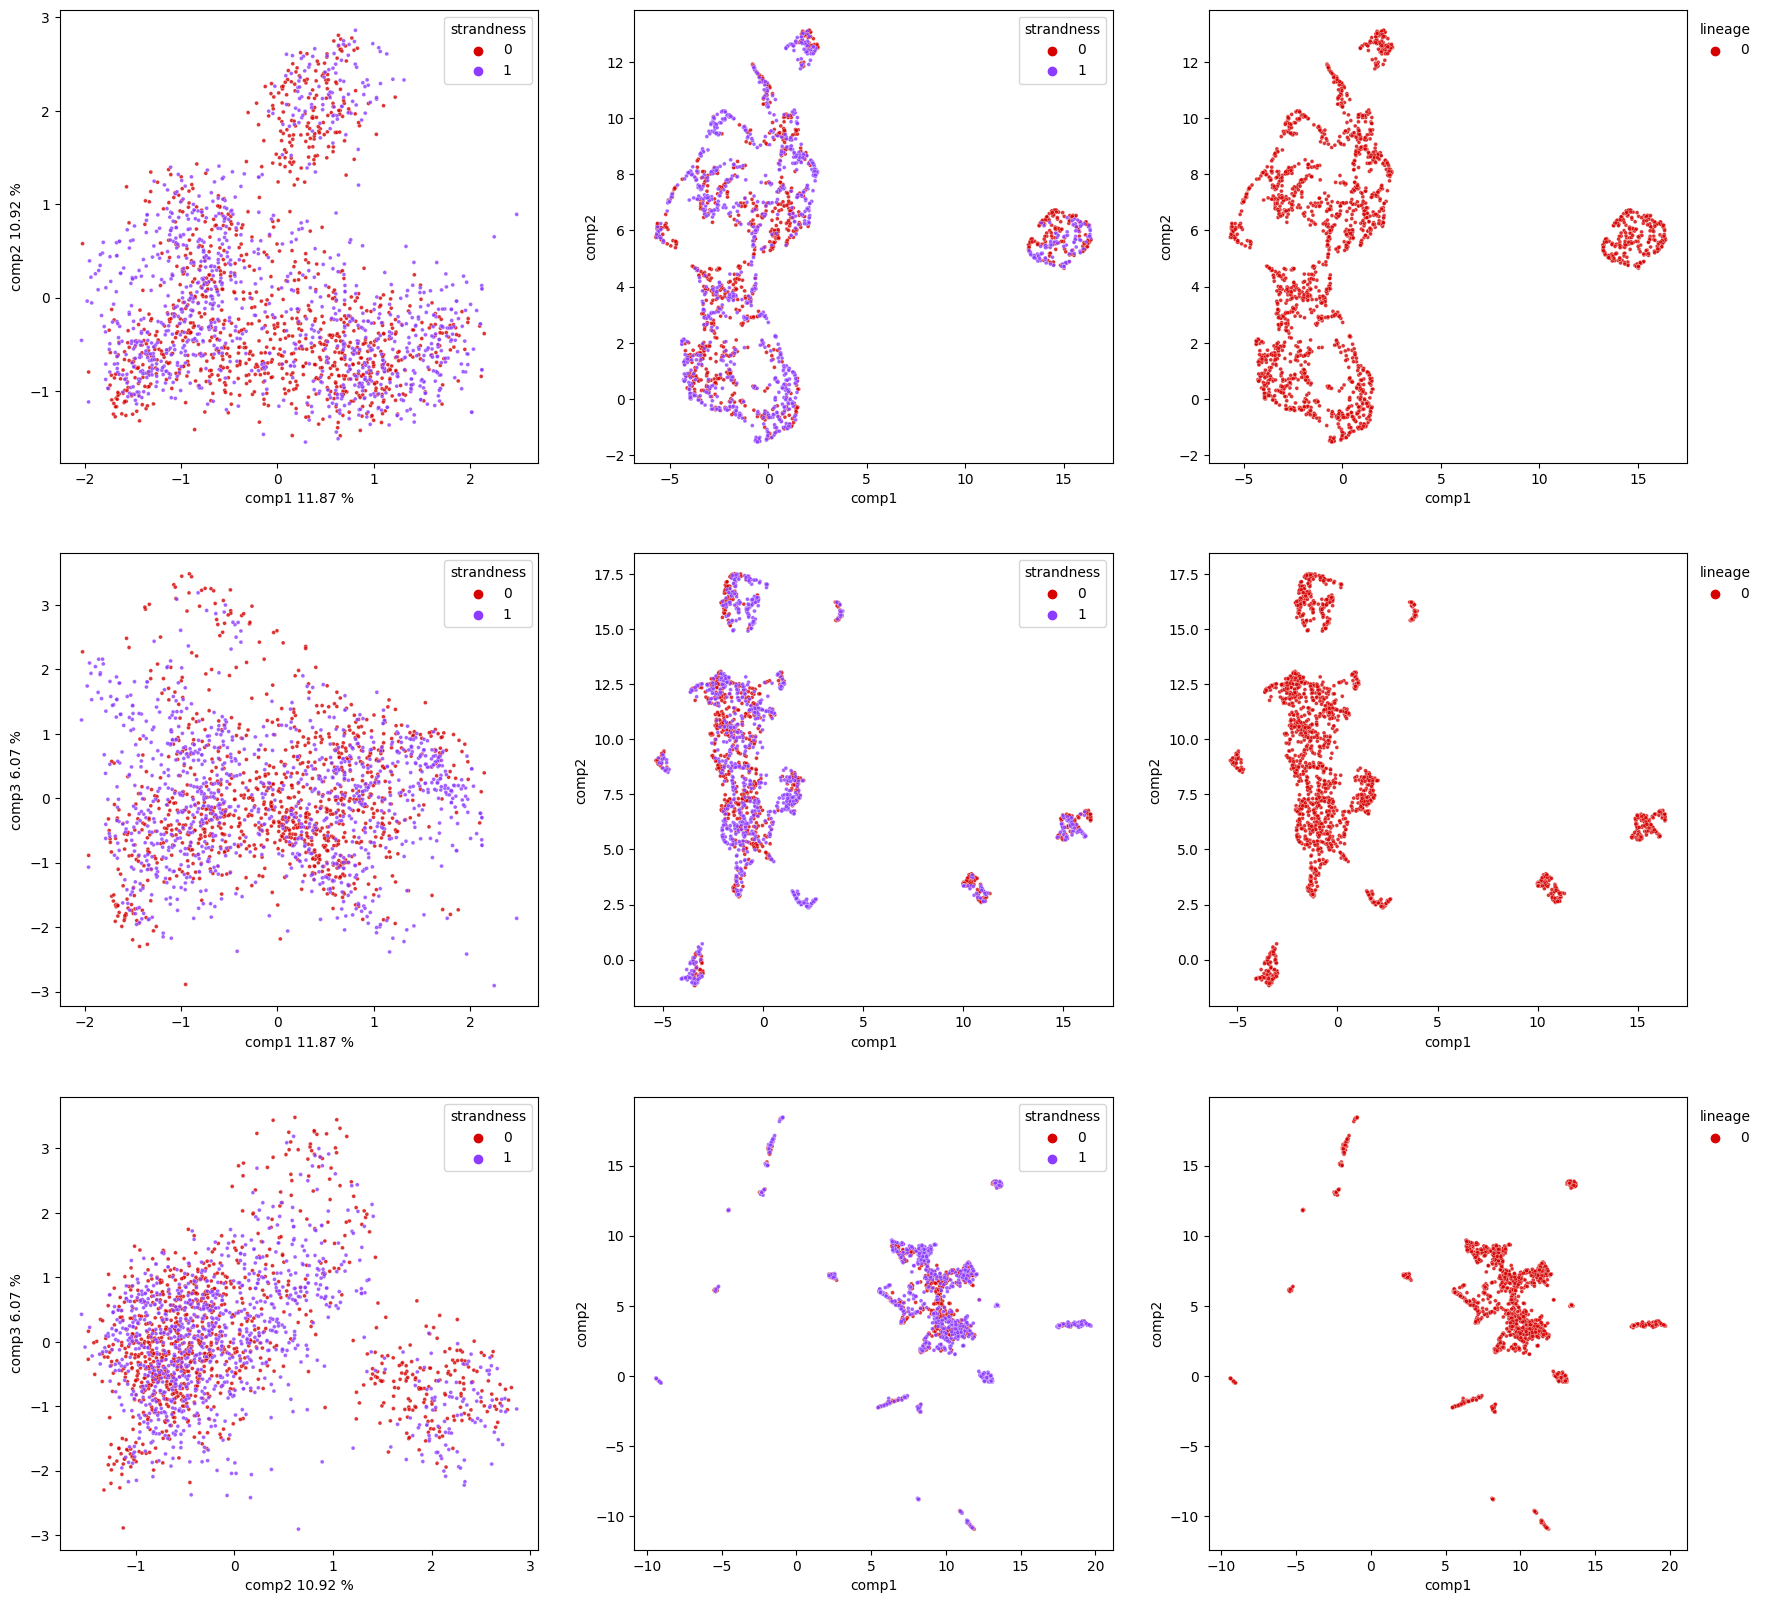

In [35]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
#     strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])
    components = pca.fit_transform(tpm_corrected_24q2.T)
    print(components.shape, strandness.shape)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


### Public

In [220]:
nonstranded_profiles = OmicsProfiles_public[OmicsProfiles_public['Stranded'] == False]['ProfileID']

In [226]:
nonstranded_model_ids_public = OmicsDefaultModelProfiles_public[OmicsDefaultModelProfiles_public['ProfileID'].isin(nonstranded_profiles)]['ModelID']

In [223]:
stranded_profiles = OmicsProfiles_public[OmicsProfiles_public['Stranded'] == True]['ProfileID']

In [227]:
stranded_model_ids_public = OmicsDefaultModelProfiles_public[OmicsDefaultModelProfiles_public['ProfileID'].isin(stranded_profiles)]['ModelID']

In [228]:
len(nonstranded_model_ids_public), len(stranded_model_ids_public)

(989, 528)

In [230]:
genes_overlap_ids_public = list(set(OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public.loc[stranded_model_ids_public].columns).intersection(set(OmicsExpressionProteinCodingGenesTPMLogp1_public.loc[nonstranded_model_ids_public].columns)))

In [231]:
nonstranded_24q2_public = OmicsExpressionProteinCodingGenesTPMLogp1_public.loc[nonstranded_model_ids_public, genes_overlap_ids_public]

In [232]:
stranded_24q2_public = OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public.loc[stranded_model_ids_public, genes_overlap_ids_public]

In [233]:
tpm_24q2_public = pd.concat((nonstranded_24q2_public, stranded_24q2_public), axis=0)

Drop the gene below from expression matrix since the variance is zero across model IDs, which leads to a divide-by-zero error when doing batch correction:

In [240]:
tpm_24q2_public = tpm_24q2_public.drop(columns=['DEFB131A (644414)'])

In [241]:
strandness_public = np.array([0] * len(nonstranded_model_ids_public) + [1] * len(stranded_model_ids_public))

In [242]:
len(strandness_public)

1517

In [243]:
from inmoose.pycombat import pycombat_norm

In [245]:
tpm_corrected_24q2_public = pycombat_norm(tpm_24q2_public.T, strandness_public)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[[0.53787105]
 [0.5945517 ]
 [1.35373763]
 ...
 [0.55000542]
 [1.75886531]
 [1.75100127]] [[False False False ... False False False]]
[[0.53787105 0.53787105 0.53787105 ... 0.53787105 0.53787105 0.53787105]
 [0.5945517  0.5945517  0.5945517  ... 0.5945517  0.5945517  0.5945517 ]
 [1.35373763 1.35373763 1.35373763 ... 1.35373763 1.35373763 1.35373763]
 ...
 [0.55000542 0.55000542 0.55000542 ... 0.55000542 0.55000542 0.55000542]
 [1.75886531 1.75886531 1.75886531 ... 1.75886531 1.75886531 1.75886531]
 [1.75100127 1.75100127 1.75100127 ... 1.75100127 1.75100127 1.75100127]]


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[WARNING] /Users/gulatide/Documents/tools/inmoose/inmoose/pycombat/pycombat_norm.py:126: RuntimeWarning: divide by zero encountered in divide
  np.amax(np.absolute(d_new - d_old) / d_old),

[INFO] Adjusting the Data


In [246]:
tpm_corrected_24q2_public

,ACH-000058,ACH-000082,ACH-000867,ACH-000437,ACH-000544,ACH-000507,ACH-000278,ACH-000011,ACH-000558,ACH-000719,...,ACH-002020,ACH-001638,ACH-001228,ACH-001711,ACH-001529,ACH-001743,ACH-001578,ACH-002669,ACH-001858,ACH-001997
ZNF891 (101060200),0.984137,1.335101,0.752579,1.589078,0.530802,-0.005338,0.493279,0.663064,0.851384,0.493279,...,1.081851,0.523504,1.742330,0.700922,1.193555,1.758635,1.468892,0.625717,0.916541,0.592368
ARMC10 (83787),4.524944,3.974294,4.698468,5.694567,5.763150,5.268909,4.775808,5.926626,5.136985,3.625671,...,4.570076,4.698240,4.845693,3.936943,4.756986,4.018689,4.371248,5.547625,5.203590,4.990152
PTGER4 (5734),2.019524,1.923885,4.105001,3.362272,0.609288,0.393061,1.400472,0.351802,0.362231,-0.017264,...,0.259181,3.210894,2.752360,2.094614,0.202498,0.466995,0.158564,0.660670,1.465734,0.995705
EIF1AD (84285),4.420996,5.944557,4.977835,4.755702,3.859448,5.206006,6.061079,3.976116,5.185275,4.857364,...,4.692058,4.596714,4.612231,5.040644,4.784246,5.061913,5.138487,5.965505,5.390739,5.304274
ABCG5 (64240),0.008593,-0.004166,-0.004166,-0.004166,-0.004166,0.021226,-0.004166,0.008593,-0.004166,0.046124,...,0.008207,0.008207,0.008207,0.028729,0.008207,0.028729,0.008207,0.069170,0.008207,0.008207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCRL6 (343413),0.118191,0.010153,0.010153,-0.003950,-0.003950,-0.003950,-0.003950,-0.003950,0.705805,-0.003950,...,0.163369,0.007287,0.094434,0.007287,0.007287,0.007287,0.007287,0.007287,0.022169,0.007287
DNMT3B (1789),2.320999,2.482620,2.047717,2.239845,1.300537,2.419582,2.547484,4.182794,1.597342,2.992605,...,2.590371,1.444929,2.697574,4.813658,6.303834,2.807276,7.984103,2.124063,2.396321,1.704941
ZCCHC10 (54819),5.005448,4.645063,4.499003,4.778812,4.562580,4.021181,3.784662,4.256767,4.925303,4.632468,...,4.435680,4.411691,5.860294,4.881553,5.036952,5.038799,5.146845,4.695655,4.408144,4.144600
PRSS2 (5645),0.169594,0.229243,0.263870,0.263870,-0.012068,3.455379,1.318720,0.341538,-0.054202,0.068637,...,0.158660,0.100699,0.100699,2.256267,0.100699,0.357770,0.100699,2.768168,0.100699,0.320037


In [247]:
tpm_corrected_24q2_public = tpm_corrected_24q2_public.T

In [249]:
tpm_corrected_24q2_public.shape

(1517, 19137)

In [248]:
tpm_corrected_24q2_public.to_csv('/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv')

In [250]:
from taigapy import default_tc as tc

new_dataset_id = tc.update_dataset(
    changes_description="adding batch corrected version to 24Q2 release",
    dataset_permaname="public-24q2-356f",
    upload_files=[
        {
            "path": "/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=True,
    upload_async=False,
    dataset_description="24Q2 release of the DepMap dataset for the DepMap Portal. Please look at the README file for additional information about this dataset.", # optional (but recommended)
)

No dataset version provided. Using version 37.
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/917d2c7ac09d48618347db15fe222e15


In [114]:
lineage_v2 = [0]*len(strandness_public)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1533, 5) (1533,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:27: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1533, 10) (1533,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1533, 30) (1533,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_49802/105524909.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)



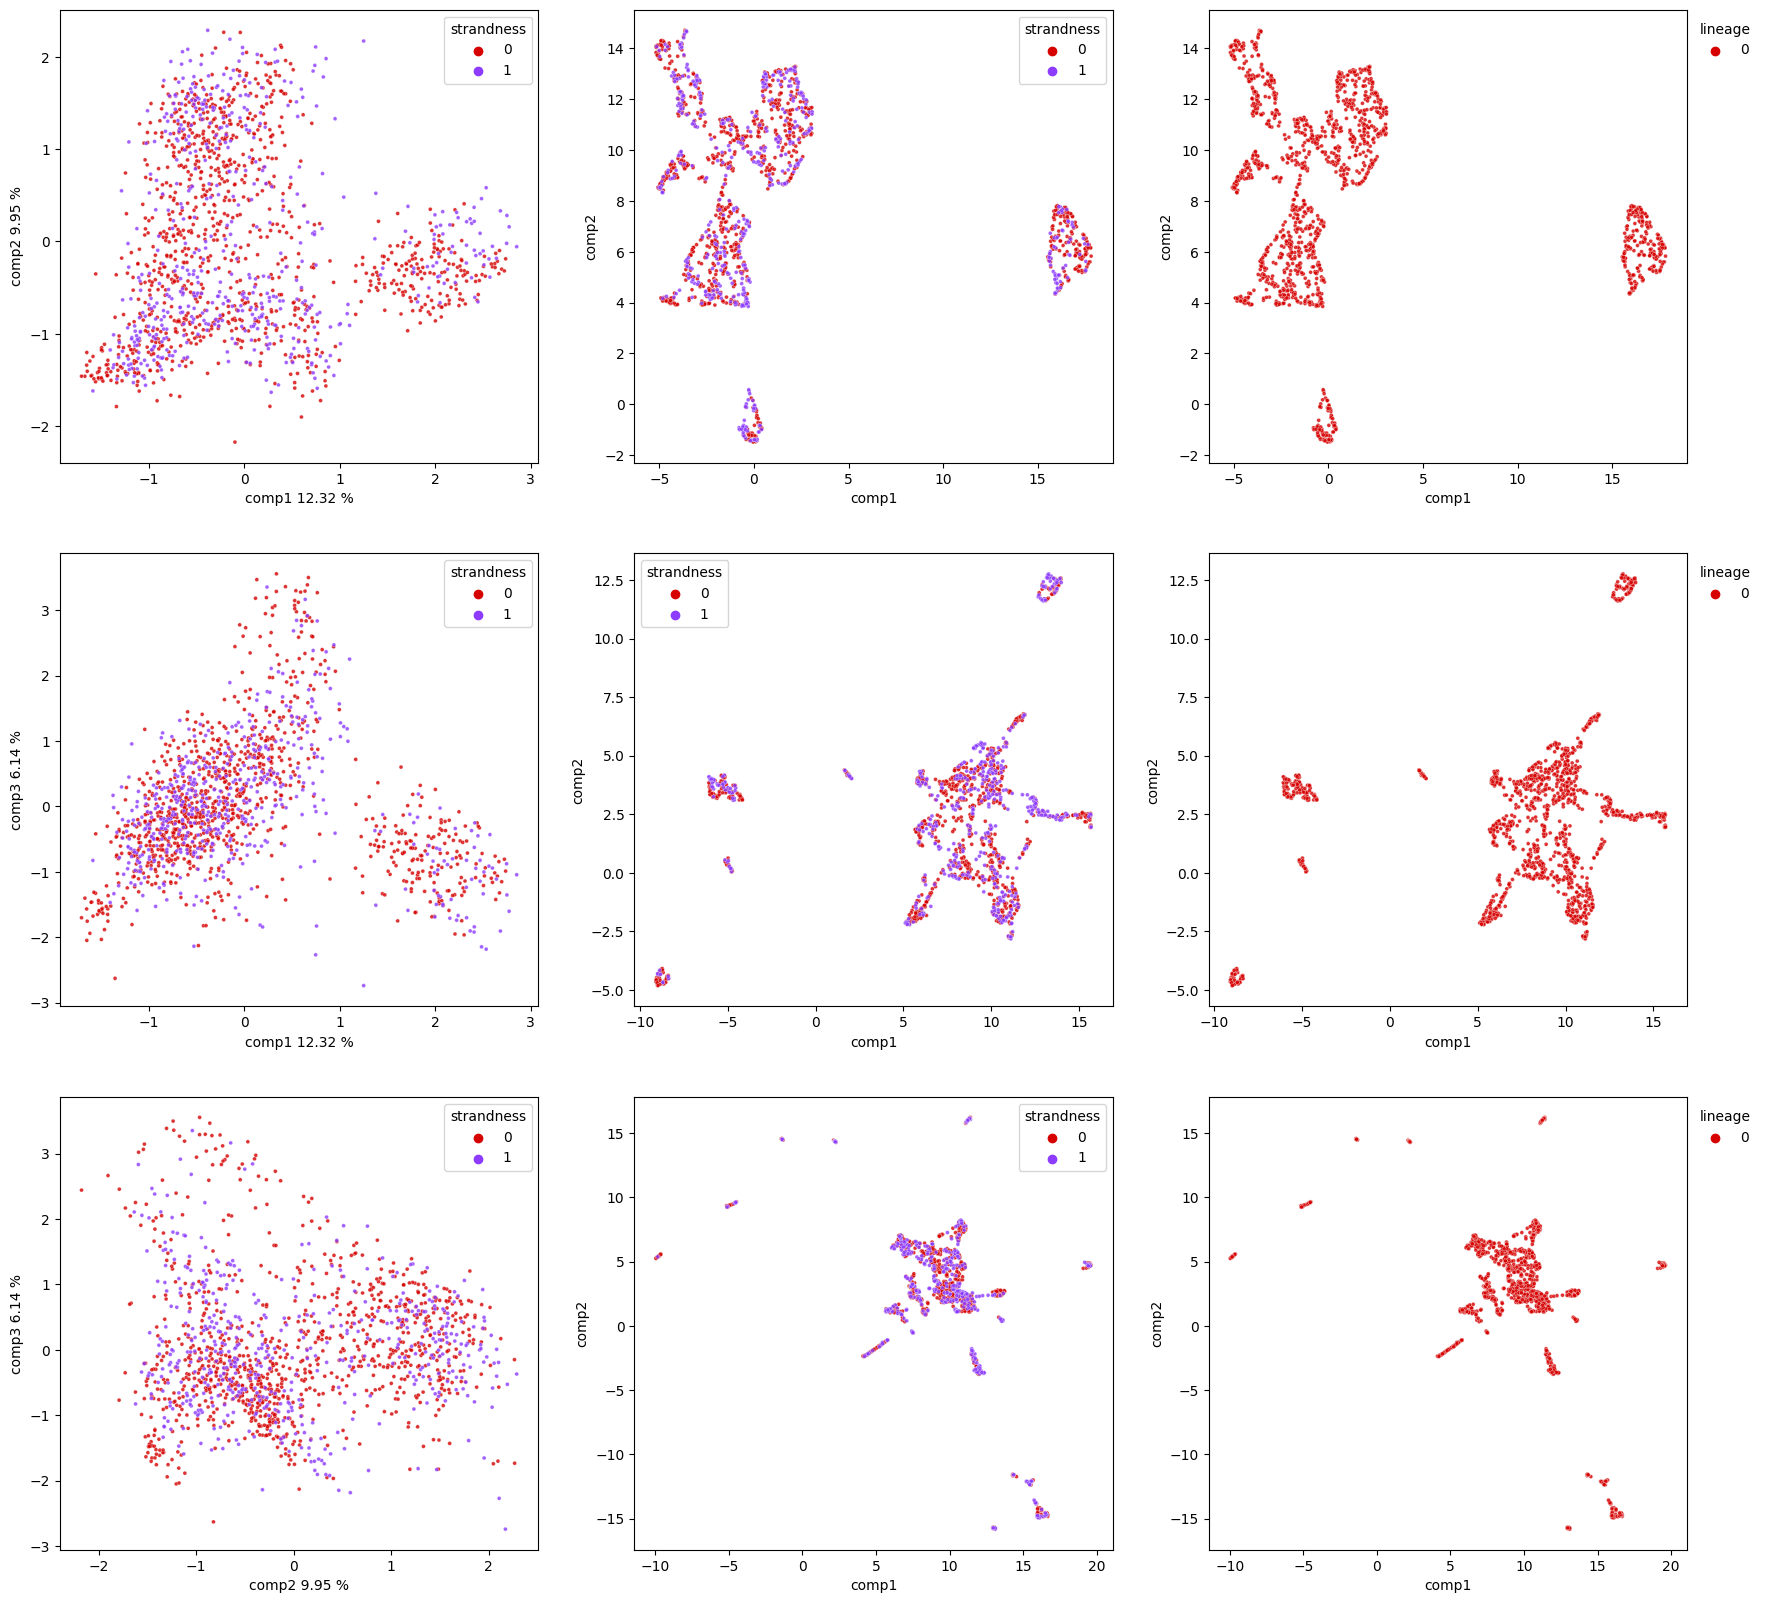

In [119]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
#     strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])
    components = pca.fit_transform(tpm_corrected_24q2_public.T)
    print(components.shape, strandness_public.shape)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


### DMC

In [197]:
nonstranded_profiles = OmicsProfiles_dmc[OmicsProfiles_dmc['Stranded'] == False]['ProfileID']

In [202]:
nonstranded_model_ids_dmc = OmicsDefaultModelProfiles_dmc[OmicsDefaultModelProfiles_dmc['ProfileID'].isin(nonstranded_profiles)]['ModelID']

In [199]:
stranded_profiles = OmicsProfiles_dmc[OmicsProfiles_dmc['Stranded'] == True]['ProfileID']

In [203]:
stranded_model_ids_dmc = OmicsDefaultModelProfiles_dmc[OmicsDefaultModelProfiles_dmc['ProfileID'].isin(stranded_profiles)]['ModelID']

In [204]:
len(nonstranded_model_ids_dmc), len(stranded_model_ids_dmc)

(986, 1003)

In [210]:
genes_overlap_ids_dmc = list(set(OmicsExpressionProteinCodingGenesTPMLogp1Stranded_dmc.loc[stranded_model_ids_dmc].columns).intersection(set(OmicsExpressionProteinCodingGenesTPMLogp1_dmc.loc[nonstranded_model_ids_dmc].columns)))

In [211]:
nonstranded_24q2_dmc = OmicsExpressionProteinCodingGenesTPMLogp1_dmc.loc[nonstranded_model_ids_dmc, genes_overlap_ids_dmc]

In [212]:
stranded_24q2_dmc = OmicsExpressionProteinCodingGenesTPMLogp1Stranded_dmc.loc[stranded_model_ids_dmc, genes_overlap_ids_dmc]

In [213]:
tpm_24q2_dmc = pd.concat((nonstranded_24q2_dmc, stranded_24q2_dmc), axis=0)

In [214]:
strandness_dmc = np.array([0] * len(nonstranded_model_ids_dmc) + [1] * len(stranded_model_ids_dmc))

In [215]:
tpm_corrected_24q2_dmc = pycombat_norm(tpm_24q2_dmc.T, strandness_dmc)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[[0.52474104]
 [0.6101267 ]
 [1.37105939]
 ...
 [0.57921899]
 [2.07502496]
 [1.68218147]] [[False False False ... False False False]]
[[0.52474104 0.52474104 0.52474104 ... 0.52474104 0.52474104 0.52474104]
 [0.6101267  0.6101267  0.6101267  ... 0.6101267  0.6101267  0.6101267 ]
 [1.37105939 1.37105939 1.37105939 ... 1.37105939 1.37105939 1.37105939]
 ...
 [0.57921899 0.57921899 0.57921899 ... 0.57921899 0.57921899 0.57921899]
 [2.07502496 2.07502496 2.07502496 ... 2.07502496 2.07502496 2.07502496]
 [1.68218147 1.68218147 1.68218147 ... 1.68218147 1.68218147 1.68218147]]


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [216]:
tpm_corrected_24q2_dmc = tpm_corrected_24q2_dmc.T

In [217]:
tpm_corrected_24q2_dmc.shape

(1989, 19138)

In [218]:
tpm_corrected_24q2_dmc.to_csv('/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv')

In [219]:
from taigapy import default_tc as tc

new_dataset_id = tc.update_dataset(
    changes_description="adding batch corrected version to 24Q2 release",
    dataset_permaname="dmc-24q2-5194",
    upload_files=[
        {
            "path": "/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=True,
    upload_async=False,
    dataset_description="24Q2 release of the DepMap dataset for the DepMap Portal. Please look at the README file for additional information about this dataset.", # optional (but recommended)
)

No dataset version provided. Using version 48.
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/51432d9082c343079c53e2a5e07e70b3
